In [77]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

In [78]:
conspiracy_5G_path = '/Users/maria/Desktop/twitterAnalysis/FakeNews/dataset/graphs/5g_corona_conspiracy/'
conspiracy_other_path = '/Users/maria/Desktop/twitterAnalysis/FakeNews/dataset/graphs/non_conspiracy/'
non_conspiracy_path = '/Users/maria/Desktop/twitterAnalysis/FakeNews/dataset/graphs/other_conspiracy/'
test_graphs_path = '/Users/maria/Desktop/twitterAnalysis/FakeNews/dataset/graphs/test_graphs/'

conspiracy_5G_N = 270
conspiracy_other_N = 1660
non_conspiracy_N = 397
test_graphs_N = 1165

In [79]:
conspiracy_5G = list()
for i in range(conspiracy_5G_N):
    g_id = i+1
    nodes_path = conspiracy_5G_path + str(g_id) + '/nodes.csv'
    edges_path = conspiracy_5G_path + str(g_id) + '/edges.txt'
    g_nodes = pd.read_csv(nodes_path) 
    g_nodes = g_nodes.set_index('id') 
    g_edges = pd.read_csv(edges_path, header = None, sep=' ')
    g_edges = g_edges.rename(columns={0: 'source', 1: 'target'})
    g = StellarGraph(g_nodes, edges=g_edges)
    conspiracy_5G.append(g)

In [80]:
conspiracy_other = list()
for i in range(conspiracy_other_N):
    g_id = i+1
    nodes_path = conspiracy_other_path + str(g_id) + '/nodes.csv'
    edges_path = conspiracy_other_path + str(g_id) + '/edges.txt'
    g_nodes = pd.read_csv(nodes_path)
    g_nodes = g_nodes.set_index('id')
    g_edges = pd.read_csv(edges_path, header = None, sep=' ')
    g_edges = g_edges.rename(columns={0: 'source', 1: 'target'})
    g = StellarGraph(g_nodes, edges=g_edges)
    conspiracy_other.append(g)

In [81]:
non_conspiracy = list()
for i in range(non_conspiracy_N):
    g_id = i+1
    nodes_path = non_conspiracy_path + str(g_id) + '/nodes.csv'
    edges_path = non_conspiracy_path + str(g_id) + '/edges.txt'
    g_nodes = pd.read_csv(nodes_path) 
    g_nodes = g_nodes.set_index('id')
    g_edges = pd.read_csv(edges_path, header = None, sep=' ')
    g_edges = g_edges.rename(columns={0: 'source', 1: 'target'})
    g = StellarGraph(g_nodes, edges=g_edges)
    non_conspiracy.append(g)

In [82]:
test_graphs_off = list()
for i in range(test_graphs_N):
    g_id = i+1
    nodes_path = test_graphs_path + str(g_id) + '/nodes.csv'
    edges_path = test_graphs_path + str(g_id) + '/edges.txt'
    g_nodes = pd.read_csv(nodes_path) 
    g_nodes = g_nodes.set_index('id')
    g_edges = pd.read_csv(edges_path, header = None, sep=' ')
    g_edges = g_edges.rename(columns={0: 'source', 1: 'target'})
    g = StellarGraph(g_nodes, edges=g_edges)
    test_graphs_off.append(g)

In [83]:
graphs = conspiracy_5G + conspiracy_other + non_conspiracy
graph_labels = pd.Series(np.repeat([1, -1], [conspiracy_5G_N, conspiracy_other_N+non_conspiracy_N], axis=0))

In [84]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

In [85]:
generator = PaddedGraphGenerator(graphs=graphs)

In [86]:
k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

In [87]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [88]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc"],
)

In [89]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.9, test_size=None, stratify=graph_labels,
)

In [90]:
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)

In [91]:
epochs = 100
history = model.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 42 steps, validate for 233 steps
Epoch 1/100


/Users/maria/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/maria/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


42/42 [==============================] - 3s 77ms/step - loss: 0.4796 - acc: 0.8047 - val_loss: 0.3492 - val_acc: 0.8841
Epoch 2/100
42/42 [==============================] - 2s 40ms/step - loss: 0.3808 - acc: 0.8840 - val_loss: 0.3455 - val_acc: 0.8841
Epoch 3/100
42/42 [==============================] - 2s 39ms/step - loss: 0.3789 - acc: 0.8840 - val_loss: 0.3448 - val_acc: 0.8841
Epoch 4/100
42/42 [==============================] - 2s 39ms/step - loss: 0.3732 - acc: 0.8840 - val_loss: 0.3450 - val_acc: 0.8841
Epoch 5/100
42/42 [==============================] - 2s 39ms/step - loss: 0.3675 - acc: 0.8840 - val_loss: 0.3440 - val_acc: 0.8841
Epoch 6/100
42/42 [==============================] - 2s 41ms/step - loss: 0.3607 - acc: 0.8840 - val_loss: 0.3446 - val_acc: 0.8841
Epoch 7/100
42/42 [==============================] - 2s 42ms/step - loss: 0.3661 - acc: 0.8840 - val_loss: 0.3444 - val_acc: 0.8841
Epoch 8/100
42/42 [==============================] - 2s 42ms/step - loss: 0.3658 - acc: 

Epoch 63/100
42/42 [==============================] - 2s 39ms/step - loss: 0.3516 - acc: 0.8840 - val_loss: 0.3372 - val_acc: 0.8841
Epoch 64/100
42/42 [==============================] - 2s 39ms/step - loss: 0.3499 - acc: 0.8840 - val_loss: 0.3375 - val_acc: 0.8841
Epoch 65/100
42/42 [==============================] - 2s 39ms/step - loss: 0.3483 - acc: 0.8840 - val_loss: 0.3377 - val_acc: 0.8841
Epoch 66/100
42/42 [==============================] - 2s 40ms/step - loss: 0.3473 - acc: 0.8840 - val_loss: 0.3380 - val_acc: 0.8841
Epoch 67/100
42/42 [==============================] - 2s 39ms/step - loss: 0.3486 - acc: 0.8840 - val_loss: 0.3376 - val_acc: 0.8841
Epoch 68/100
42/42 [==============================] - 2s 39ms/step - loss: 0.3555 - acc: 0.8840 - val_loss: 0.3380 - val_acc: 0.8841
Epoch 69/100
42/42 [==============================] - 2s 39ms/step - loss: 0.3544 - acc: 0.8840 - val_loss: 0.3376 - val_acc: 0.8841
Epoch 70/100
42/42 [==============================] - 2s 39ms/step - 

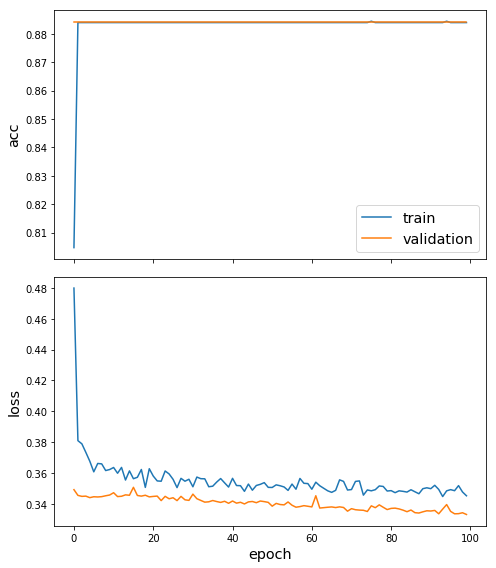

In [92]:
sg.utils.plot_history(history)

In [93]:
test_gen_off = PaddedGraphGenerator(graphs=test_graphs_off)
test_gen_off_f = test_gen_off.flow(graphs=test_graphs_off)
preds = model.predict(test_gen_off_f)

(array([ 22.,  72., 611., 248.,  78.,  47.,  19.,  21.,  30.,  17.]),
 array([0.02340826, 0.06282817, 0.10224808, 0.14166799, 0.1810879 ,
        0.22050782, 0.25992772, 0.29934764, 0.33876756, 0.37818745,
        0.41760737], dtype=float32),
 <a list of 10 Patch objects>)

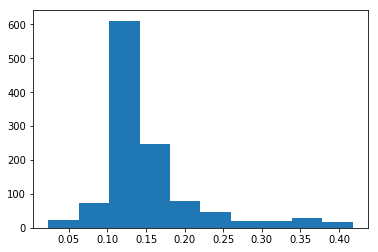

In [94]:
import matplotlib.pyplot as plt
plt.hist(preds)

In [95]:
print(preds)

[[0.12391277]
 [0.13464499]
 [0.16950193]
 ...
 [0.25458154]
 [0.14482737]
 [0.11278567]]


In [ ]:
# Sources

# https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html